In [13]:
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import packages
import xarray as xr
import xesmf as xe
import intake
import util 
import pprint 
import matplotlib.pyplot as plt

## Plot CESM2 global average 2 meter temperature under different emissions scenarios 
##### Note: There is no area weighting here, so that numbers are too low! But you get the point...

In [42]:
# Querry data catalog 
col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
cat = col.search(experiment_id=['ssp126', 'ssp370', 'ssp585'], source_id=['CESM2'], variable_id=['tas'])
ds = cat.to_dataset_dict()
print(list(ds))

# Create xarray data arrays
ssp_126 = ds['ScenarioMIP.NCAR.CESM2.ssp126.Amon.gn']['tas'] - 273.15
ssp_370 = ds['ScenarioMIP.NCAR.CESM2.ssp370.Amon.gn']['tas'] - 273.15
ssp_585 = ds['ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn']['tas'] - 273.15


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)
['ScenarioMIP.NCAR.CESM2.ssp126.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp126.day.gn', 'ScenarioMIP.NCAR.CESM2.ssp370.3hr.gn', 'ScenarioMIP.NCAR.CESM2.ssp370.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp370.day.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.day.gn']


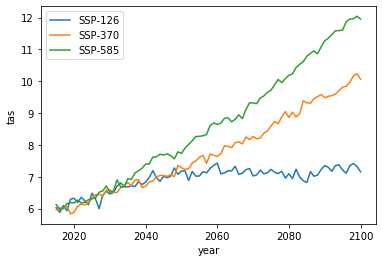

In [15]:
# Plot
ssp_126.mean(dim='lat').mean(dim='lon').squeeze()\
    .groupby('time.year').mean('time').plot(label='SSP-126')
ssp_370.mean(dim='lat').mean(dim='lon').mean(dim='member_id').squeeze()\
    .groupby('time.year').mean('time').plot(label='SSP-370')
ssp_585.mean(dim='lat').mean(dim='lon').mean(dim='member_id').squeeze().\
    groupby('time.year').mean('time').plot(label='SSP-585')
plt.legend()

## Plot historical global precipitation from diferent models
##### Note: Again there is no area weighting here. 

In [57]:
# Querry data catalog 
col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
cat = col.search(experiment_id=['historical'], variable_id=['prc'])
ds = cat.to_dataset_dict()
print(list(ds))


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 37 group(s)
['CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn', 'CMIP.BCC.BCC-ESM1.historical.Amon.gn', 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn', 'CMIP.CAS.FGOALS-g3.historical.Amon.gn', 'CMIP.CAS.FGOALS-g3.historical.day.gn', 'CMIP.CCCma.CanESM5.historical.Amon.gn', 'CMIP.CCCma.CanESM5.historical.day.gn', 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Amon.gr', 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.day.gr', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Amon.gr', 'CMIP.E3SM-Project.E3SM-1-0.historical.Amon.gr', 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.Amon.gr', 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.day.gr', 'CMIP.EC-Earth-Con

CMIP.E3SM-Project.E3SM-1-0.historical.Amon.gr


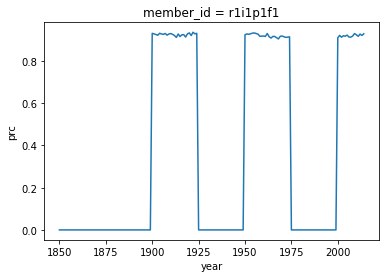

In [58]:
string = list(ds)[10]
print(string)
tmp = ds[string]['prc'].sum(dim='lat').sum(dim='lon').groupby('time.year').mean('time')[0,:]
tmp.plot()



In [59]:
tmp

<xarray.DataArray 'prc' (year: 165)>
dask.array<getitem, shape=(165,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014